# Init

In [1]:
import os
import operator
import csv
import json
import datetime as dt
import numpy as np
import pandas as pd
import math
import random
import scipy

from sklearn.preprocessing import normalize
from scipy.optimize import minimize
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.patheffects as path_effects

import seaborn as sns

%matplotlib inline

Run prefix in the format run_data version_number of topics. For example run_02_05 will use dtm model trained on data vertion 02 (strict English vocabolary) and 5 topics

In [2]:
data_procecing_run = 19
number_of_topics = '22'

In [3]:
run_prefix = 'run_%s_%s' % (data_procecing_run, number_of_topics)

In [4]:
dir_root = os.path.join('..')
dir_data_raw = os.path.join(dir_root, "data_raw")
dir_data = os.path.join(dir_root, 'data_processing')
dir_tickers = os.path.join(dir_data, 'tickers')
dir_run = os.path.join(dir_root, 'data_runs', run_prefix)
dir_result_dtm = os.path.join(dir_run, 'results', 'lda-seq')
dir_result_interpretation = os.path.join(dir_run, 'interpretation')

## Flags and settings

In [5]:
flag_debug_company_topic_distribution_plots = False
flag_generate_company_topic_distribution_individual_plots = False
flag_generate_company_topic_distribution_plots_on_grid = True
flag_plot_industries_indecies = False

## Read topics amount and time slices amount

In [6]:
number_of_topics = None
time_slices = None
with open(os.path.join(dir_result_dtm, 'info.dat'), 'r') as f_r:
    for text_line in f_r:
        data = text_line.strip().split(' ')
        if data[0] == 'NUM_TOPICS':
            number_of_topics = int(data[1])
        if data[0] == 'SEQ_LENGTH':
            time_slices = int(data[1])
            
print("Number of topics: %s" % number_of_topics) 
print("Number of years: %s" % time_slices)

Number of topics: 22
Number of years: 13


In [7]:
# TODO build years seq here

In [8]:
year_series = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

# Terms

Get whole dictionaly

In [9]:
terms_list = []
with open(os.path.join(dir_run, "%s-terms.dat" % run_prefix), 'r') as f_r:
    for text_line in f_r:
        term = text_line.strip()
        if len(term):
            terms_list.append(term)

## Get top terms for every topic

In [10]:
take_top_terms = 5
flag_is_exp = True

In [11]:
dir_result_top_terms = os.path.join(dir_result_interpretation, 'top_terms')
if not os.path.exists(dir_result_top_terms):
    os.makedirs(dir_result_top_terms)

In [12]:
def get_sorted_terms(topic_id):
    #create time slice data
    all_time_slices_data_unsorted = {}
    for time_slice in range(time_slices):
        all_time_slices_data_unsorted[time_slice] = list()

    #open terms distribution file
    with open(os.path.join(dir_result_dtm, "topic-%s-var-e-log-prob.dat" % topic_id), 'r') as f_r:
        distributions = f_r.readlines()
        dist_x = 0
        #for each term read one line
        for term in terms_list:
            # for each time slice
            for time_slice in range(time_slices):
                float_text = distributions[dist_x].strip()
                if len(float_text):
                    if flag_is_exp:
                        term_probability = math.exp(float(float_text))
                    else:
                        term_probability = float(float_text)
                    all_time_slices_data_unsorted[time_slice].append((term, term_probability))
                dist_x += 1

    # sort list
    all_time_slices_data_sorted = []
    for time_slice in range(time_slices):
        all_time_slices_data_sorted.append(sorted(all_time_slices_data_unsorted[time_slice],
                                                  key=operator.itemgetter(1),
                                                  reverse=True))
    
    return all_time_slices_data_sorted

In [13]:
def store_sorted_terms(topic_id, all_time_slices_data_sorted):
    #in terms_rank we will store skore for a term (higher first)
    terms_rank = {}
    
    #save as csv without probabilities for better visualisation and limited to take top
    file_csv_sorted_terms_without_probabilities = os.path.join(dir_result_top_terms, "%s-terms-in-time.csv" % topic_id)
    with open(file_csv_sorted_terms_without_probabilities, 'w') as f_w:
        for i in range(take_top_terms):
            terms_at_position_list = []
            for time_slice in range(time_slices):
                term = all_time_slices_data_sorted[time_slice][i][0]
                if term not in terms_rank:
                    terms_rank[term] = 0
                terms_rank[term] += (take_top_terms - i)
                terms_at_position_list.append(term)
            f_w.write("%s\n" % (','.join(terms_at_position_list)))
    
    #save as csv without probabilities and time slices for better visualisation and limited to take top
    file_csv_sorted_terms_summary = os.path.join(dir_result_top_terms, "%s-terms-summary.csv" % topic_id)
    with open(file_csv_sorted_terms_summary, 'w') as f_w:
        terms_summary = [x[0] for x in sorted(terms_rank.items(), key = operator.itemgetter(1), reverse=True)]
        for i in range(take_top_terms):
            f_w.write("%s\n" % terms_summary[i])
            
    #save as csv with probabilities
    file_csv_sorted_terms_with_probabilities = os.path.join(dir_result_top_terms, "%s-terms_sorted.csv" % topic_id)
    with open(file_csv_sorted_terms_with_probabilities, 'w') as f_w:
        for i in range(len(terms_list)):
            terms_at_position_list = list()
            for time_slice in range(time_slices):
                terms_at_position_list.append(all_time_slices_data_sorted[time_slice][i][0])
                terms_at_position_list.append(all_time_slices_data_sorted[time_slice][i][1])
            f_w.write("%s\n" % (','.join(map(str, terms_at_position_list))))

In [14]:
for i in range(number_of_topics):
    sorted_terms = get_sorted_terms("%03d" % i)
    store_sorted_terms("%03d" % i, sorted_terms)

## Plot topics evolution

In [15]:
dir_top_terms_plots = os.path.join(dir_result_interpretation, 'top_terms_plots')
if not os.path.exists(dir_top_terms_plots):
    os.makedirs(dir_top_terms_plots)

### Generate as plot

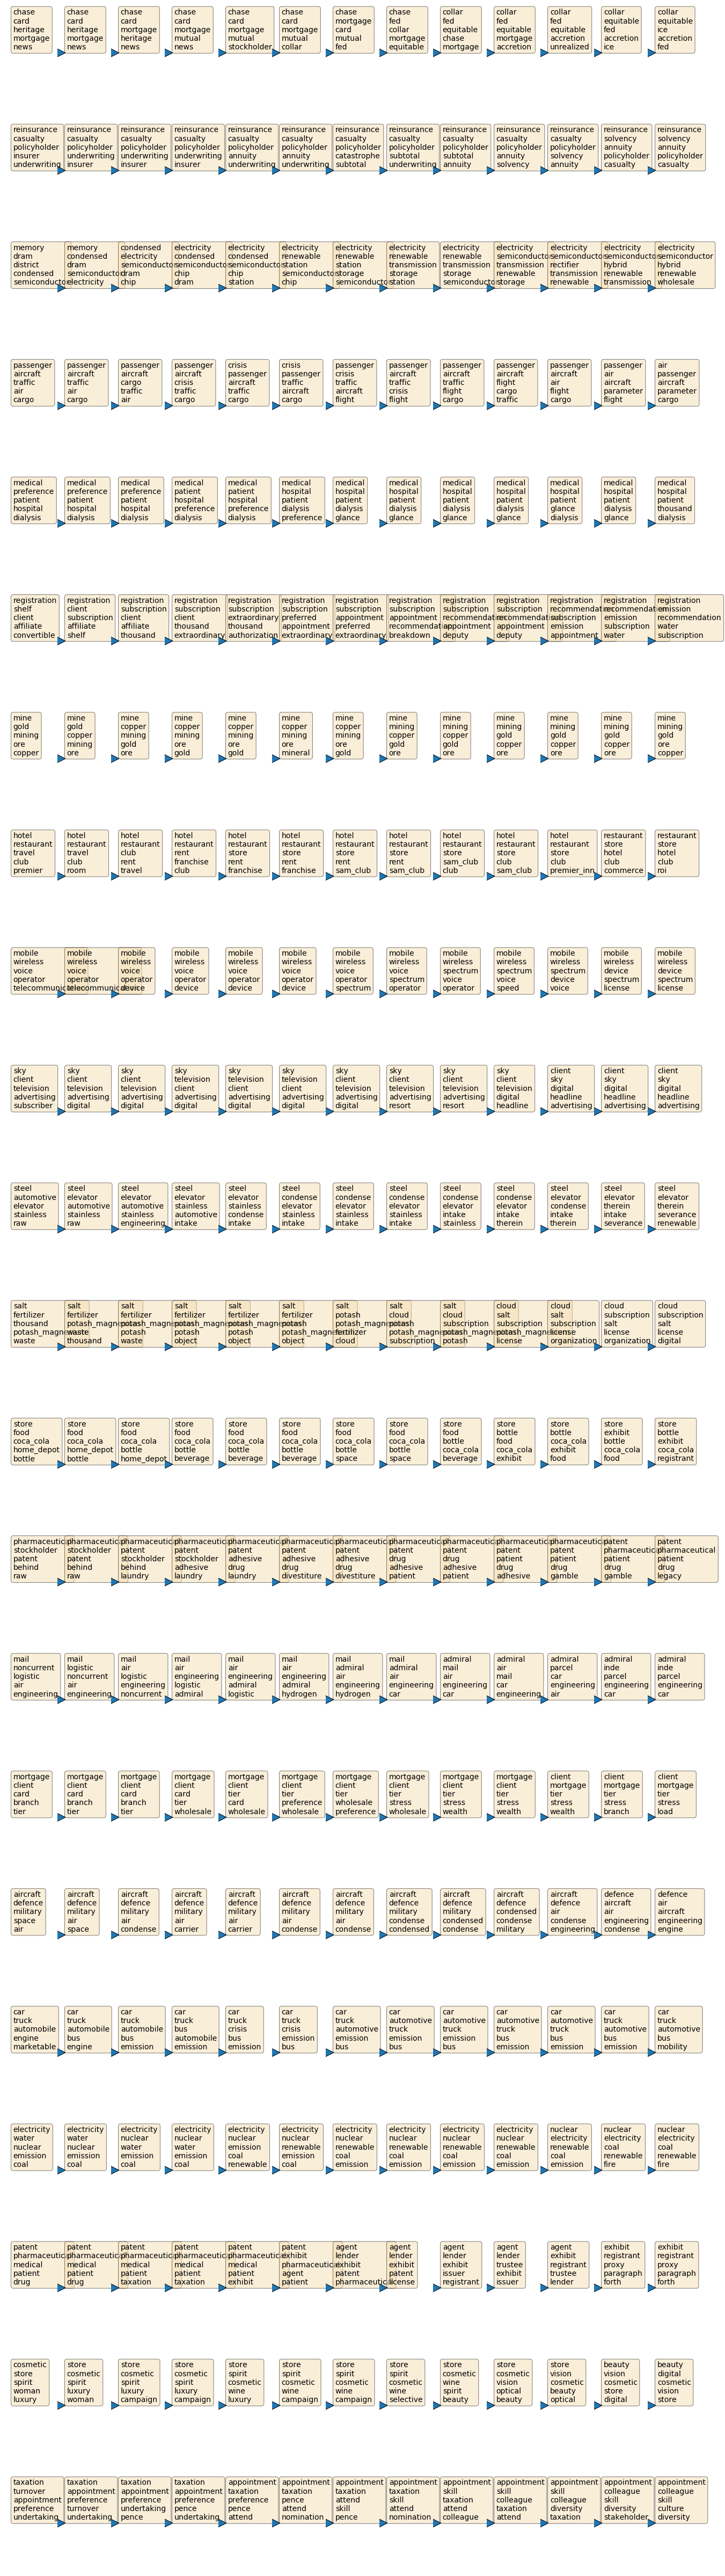

In [16]:
columns = time_slices
rows = number_of_topics#2#number_of_topics
f, ax = plt.subplots(rows, columns, figsize=(23, 4*rows))
text_box_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for topic_index, topic_id in enumerate(range(number_of_topics)): #range(number_of_topics):
    file_csv_sorted_terms = os.path.join(dir_result_top_terms, "%03d-terms-in-time.csv" % topic_id)
    df_terms_for_topic = pd.read_csv(file_csv_sorted_terms, names=year_series, header=None)    
    for year_index, year in  enumerate(year_series): 
        ax[topic_index, year_index].set_axis_off()
        terms = '\n'.join(df_terms_for_topic[year])
        ax[topic_index, year_index].text(0.21, 0.95, terms, transform=ax[topic_index, year_index].transAxes, 
                             fontsize=14, verticalalignment='top', bbox=text_box_props)
        if year_index > 0:
            arrow = mpatches.FancyArrowPatch((0.0, 0.5), (0.2, 0.5),
                                     mutation_scale=50,
                                     transform=ax[topic_index, year_index].transAxes)
            ax[topic_index, year_index].add_patch(arrow)
pp = PdfPages(os.path.join(dir_top_terms_plots, "terms_in_topics_evolution_topic.pdf"))
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()    

### Generate as LaTeX table

In [17]:
print('\\begin{tabular}{c|%s}' % '|'.join(['c'] * time_slices))
print('\\hline')
print('\\textbf{Topic Id} & %s \\\\ ' % ' & '.join(['\\textbf{%s}' % x for x in year_series]))
print('\\hline') 
for topic_index, topic_id in enumerate(range(number_of_topics)):
    file_csv_sorted_terms = os.path.join(dir_result_top_terms, "%03d-terms-in-time.csv" % topic_id)
    df_terms_for_topic = pd.read_csv(file_csv_sorted_terms, names=year_series, header=None) 
    
    for i, top_n in enumerate(range(take_top_terms)):
        row = []
        for year_index, year in  enumerate(year_series): 
            row.append(df_terms_for_topic[year][top_n])
        if i == 0:
            print('%s & %s \\\\ ' % (topic_id, ' & '.join([x.replace('_', ' ') for x in row])))
        else:
            print(' & %s \\\\ ' % ' & '.join([x.replace('_', ' ') for x in row]))
    print('\\hline')


\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c|c|c}
\hline
\textbf{Topic Id} & \textbf{2005} & \textbf{2006} & \textbf{2007} & \textbf{2008} & \textbf{2009} & \textbf{2010} & \textbf{2011} & \textbf{2012} & \textbf{2013} & \textbf{2014} & \textbf{2015} & \textbf{2016} & \textbf{2017} \\ 
\hline
0 & chase & chase & chase & chase & chase & chase & chase & chase & collar & collar & collar & collar & collar \\ 
 & card & card & card & card & card & card & mortgage & fed & fed & fed & fed & equitable & equitable \\ 
 & heritage & heritage & mortgage & mortgage & mortgage & mortgage & card & collar & equitable & equitable & equitable & fed & ice \\ 
 & mortgage & mortgage & heritage & mutual & mutual & mutual & mutual & mortgage & chase & mortgage & accretion & accretion & accretion \\ 
 & news & news & news & news & stockholder & collar & fed & equitable & mortgage & accretion & unrealized & ice & fed \\ 
\hline
1 & reinsurance & reinsurance & reinsurance & reinsurance & reinsurance & reinsurance 

# Topic distribuion (gammas)

read reports in list

In [18]:
reports_list = []
with open(os.path.join(dir_run, "%s-documents.dat" % run_prefix), 'r') as f_r:
    for text_line in f_r:
        report_name = text_line.strip()
        if len(report_name):
            reports_list.append(report_name)

In [19]:
gamma_for_reports = {}

In [20]:
with open(os.path.join(dir_result_dtm, 'gam.dat'), 'r') as f_r:
    distributions = f_r.readlines()
    dist_x = 0
    #for each term read one line
    for report in reports_list:
        # for each topic
        normalization_sum = 0
        topics_probabilities = []
        topics_probabilities_normalize = []

        for topic in range(number_of_topics):
            float_text = distributions[dist_x].strip()
            topic_probability = float(float_text)
            topics_probabilities.append(topic_probability)
            normalization_sum += topic_probability
            dist_x += 1

        for prob in topics_probabilities:
            topics_probabilities_normalize.append(prob / normalization_sum)
        gamma_for_reports[report] = topics_probabilities_normalize

Store to scv file with gammas for every report

In [21]:
dir_result_topics_proportions = os.path.join(dir_result_interpretation, 'topics_proportions')
if not os.path.exists(dir_result_topics_proportions):
    os.makedirs(dir_result_topics_proportions)

In [22]:
file_csv_topic_proportion = os.path.join(dir_result_topics_proportions, 'topic-proportion-for-docs.csv')
with open(file_csv_topic_proportion, 'w') as f_w:
    for report in gamma_for_reports:
        f_w.write("%s,%s\n" % (report, (','.join(map(str, gamma_for_reports[report])))))

Aggregate reports by company and store them by year

In [23]:
gamma_for_reports_by_years = {}

In [24]:
for report in gamma_for_reports:
    ### old report name before 17
    if data_procecing_run < 17:
        report_data = report.split('-')
        company_name = report_data[0]
        report_year = report_data[1]
    ### new report name 17 and after
    else:
        report_data = report.split('-')
        company_name = report_data[0]
        report_year = report_data[1].split('_')[0]
        
    if report_year not in gamma_for_reports_by_years:
        gamma_for_reports_by_years[report_year] = {}
    if company_name not in gamma_for_reports_by_years[report_year]:
        gamma_for_reports_by_years[report_year][company_name] = []
    gamma_for_reports_by_years[report_year][company_name].append(gamma_for_reports[report])



Average reports for every company's year, re-normalize gammas

In [25]:
final_gammas = {}

In [26]:
for report_year in gamma_for_reports_by_years:
    final_gammas[report_year] = {}
    for ticker in gamma_for_reports_by_years[report_year]:
        m = np.array(gamma_for_reports_by_years[report_year][ticker])
        means = m.mean(axis=0)
        normalized = means / np.sum(means)
        final_gammas[report_year][ticker] = normalized

Define year series

In [27]:
test_year_series = []

Save topic destribution for every compnay over the years

In [28]:
for report_year in final_gammas:
    # append year to year series
    test_year_series.append(int(report_year))
    
    tickers_list = sorted(list(final_gammas[report_year].keys()))

    file_csv_topic_proportion_for_year = os.path.join(dir_result_topics_proportions, "topic-proportion-%s.csv" % report_year)
    with open(file_csv_topic_proportion_for_year, 'w') as f_w:
        f_w.write("%s\n" % ','.join(tickers_list))
        for topic_id in range(number_of_topics):
            topic_values = list()
            for company_name in tickers_list:
                topic_values.append(final_gammas[report_year][company_name][topic_id])
            f_w.write("%s\n" % ','.join(list(map(str, topic_values))))

re-sort years series

In [29]:
test_year_series.sort()
print("Years series: %s" % year_series)
print(" TEST series: %s" % test_year_series)

Years series: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
 TEST series: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


## Topic distribution plots

In [30]:
#viridis
#rainbow 
#gist_ncar
#terrain

In [31]:
colors_map = plt.cm.get_cmap('rainbow', number_of_topics)
colors_topic = [colors_map(x) for x in range(number_of_topics)]

In [32]:
color_north = colors_topic[4]
color_south = colors_topic[-4]
color_north_rgba = [int(x * 255) for x in colors_topic[4]]
color_south_rgba = [int(x * 255) for x in colors_topic[-4]]
color_north_rgba[-1] = int(color_north_rgba[-1] / 255)
color_south_rgba[-1] = int(color_south_rgba[-1] / 255)

### Oposite colors rgb

In [33]:
print(color_north_rgba)
print(color_south_rgba)

[30, 143, 243, 1]
[255, 110, 56, 1]


### Oposite colors rgba float

In [34]:
print(color_north)
print(color_south)

(0.11904761904761907, 0.563320058063622, 0.9555728057861408, 1.0)
(1.0, 0.43388373911755823, 0.22252093395631445, 1.0)


In [35]:
topics_names = [("Topic %03d" % x) for x in range(number_of_topics)]

In [36]:
file_ticker_to_name = os.path.join(dir_tickers, 'tickers_names_map.csv')
companies_names = {}
with open(file_ticker_to_name, 'r') as f_r:
    for t_l in f_r:
        o = t_l.strip().split(',')
        companies_names[o[0]] = o[1]

## Topic distribution

All plots with topic distribution per company will be saved to the pdf files
To show inline a plot for random fraction of companies please set visible_percentage var

In [37]:
visible_percentage = 100

In [38]:
dir_topic_proportion_plots = os.path.join(dir_result_interpretation, 'topics_proportions_plots')
file_tickers_for_analysis = os.path.join(dir_tickers, 'tiker_for_analysis.data')

In [39]:
if not os.path.exists(dir_topic_proportion_plots):
    os.mkdir(dir_topic_proportion_plots)

In [40]:
topic_proportions_data = {}

In [41]:
tickers_set = set()
for year in year_series:
    topic_proportions_data[year] = {}
    file_topic_proportions = os.path.join(dir_result_topics_proportions, "topic-proportion-%s.csv" % year)
    df_topic_proportions = pd.read_csv(file_topic_proportions)
    for ticker in df_topic_proportions:
        tickers_set.add(ticker)
        topic_proportions_data[year][ticker] = df_topic_proportions[ticker]    

In [42]:
tickers_list = list(sorted(tickers_set))

In [43]:
top_n_terms = {}
for topic_id in range(number_of_topics):
    file_csv_sorted_terms_summary = os.path.join(dir_result_top_terms, "%03d-terms-summary.csv" % topic_id)
    top_n_terms[topic_id] = [x.strip() for x in open(file_csv_sorted_terms_summary, "r")]

Set how many top terms will be added to a legent for a plot

In [44]:
take_top_terms = 3

In [45]:
def plot_ticker_topic_distribution(ticker, warnings):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))

    bar_width = 1
    bar_l = [i for i in range(len(year_series))]
    tick_pos = [i for i in bar_l]
    
    ax.set_title("Topic distribution for %s (%s)" % (companies_names[ticker], ticker))
    ax.set_ylabel("Proportions")
    ax.set_xlabel("Years")
    
    on_bottom = np.zeros(len(year_series))
    patch_handles = []
    
    for year in year_series:
        if ticker not in topic_proportions_data[year]:
            warnings.append('Warning missing data for %s - %s' % (ticker, year))
            topic_proportions_data[year][ticker] = [1 / number_of_topics] * number_of_topics 
            
    for topic_id in range(number_of_topics):
        plot_data = [topic_proportions_data[year][ticker][topic_id] for year in year_series] 
        patch_handles.append(
            ax.bar(
                bar_l, 
                plot_data, 
                bottom=on_bottom, 
                label="topic %s: %s" % (topic_id,", ".join(top_n_terms[topic_id][:take_top_terms])),
                color=colors_topic[topic_id], width=bar_width, edgecolor='white')
        )
        on_bottom = [previous + current for previous, current in zip(on_bottom, plot_data)]
    
    for topic_id in range(len(patch_handles)):
        for year_index, patch in enumerate(patch_handles[topic_id].get_children()):
            if topic_proportions_data[year_series[year_index]][ticker][topic_id] >= 0.15:
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                t = ax.text(x,y, topic_id, ha='center', color='navy')
                t.set_path_effects([
                        path_effects.Stroke(linewidth=4,foreground='ivory'),
                        path_effects.Normal()])

    plt.xticks(tick_pos, year_series)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, bbox_to_anchor=(1.002, 1.019), loc=2, ncol=2, handleheight=2.4, labelspacing=0.05)
    
    if flag_debug_company_topic_distribution_plots:
        plt.show()

    #save plot
    pp = PdfPages(os.path.join(dir_topic_proportion_plots, "%s.pdf" % ticker))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()
    
    plt.close()

In [46]:
if flag_generate_company_topic_distribution_individual_plots:
    warnings = []
    for ticker in tickers_list:
        plot_ticker_topic_distribution(ticker, warnings)
    
    print(warnings)

In [47]:
rows_on_page = 5
columns_on_page = 2
plots_on_page = rows_on_page * columns_on_page
number_of_pages = math.ceil(len(tickers_list) / plots_on_page)

In [48]:
global_ticker_iterator = 0
for page in range(number_of_pages):
    
    f, axs = plt.subplots(
        rows_on_page,
        columns_on_page,
        figsize=(10,11.69), # A4 landscape(11.69,8.27)
        ) 
    
    #f.suptitle('Topic distribution for companies in the experiment', fontsize=16)
    f.tight_layout(pad=3.0)
    for row in range(rows_on_page):
        for column_index in range(columns_on_page):
            ax = axs[row][column_index]
            
            if global_ticker_iterator >= len(tickers_list):
                ax.axis('off')
                continue
                
            ticker = tickers_list[global_ticker_iterator]
            global_ticker_iterator += 1
            
            bar_width = 1
            bar_l = [i for i in range(len(year_series))]
            tick_pos = [i for i in bar_l]

            ax.set_title('%s (%s)' % (companies_names[ticker], ticker))
            if column_index == 0:
                ax.set_ylabel("Proportions")
            if row ==  rows_on_page - 1:
                ax.set_xlabel("Years")

            on_bottom = np.zeros(len(year_series))
            patch_handles = []
            for topic_id in range(number_of_topics):
                for year in year_series:
                    if ticker not in topic_proportions_data[year]:
                        print('Missing document: %s for %s' % (ticker, year))
                plot_data = [topic_proportions_data[year][ticker][topic_id] for year in year_series] 
                patch_handles.append(
                    ax.bar(
                        bar_l, 
                        plot_data, 
                        bottom=on_bottom, 
                        label="topic %s: %s" % (topic_id,", ".join(top_n_terms[topic_id][:take_top_terms])),
                        color=colors_topic[topic_id], width=bar_width, edgecolor='white')
                )
                on_bottom = [previous + current for previous, current in zip(on_bottom, plot_data)]                    

            for topic_id in range(len(patch_handles)):
                for year_index, patch in enumerate(patch_handles[topic_id].get_children()):
                    if ticker in topic_proportions_data[year_series[year_index]] and topic_proportions_data[year_series[year_index]][ticker][topic_id] >= 0.15:
                        bl = patch.get_xy()
                        x = 0.5*patch.get_width() + bl[0]
                        y = 0.5*patch.get_height() + bl[1]
                        t = ax.text(x,y, topic_id, ha='center', color='navy')
                        t.set_path_effects([
                                path_effects.Stroke(linewidth=4,foreground='ivory'),
                                path_effects.Normal()])
            
            ax.set_ylim(0, 1)
            ax.set_xticks(tick_pos)
            ax.set_xticklabels(year_series, rotation=45, rotation_mode="anchor", horizontalalignment='right')

    first_ax = axs[0][0]

    handles, labels = first_ax.get_legend_handles_labels()
    lgd = first_ax.legend(handles, labels, bbox_to_anchor=(1.1, -8.3), loc="lower center", ncol=2, handleheight=2.4, labelspacing=0.05)

    #save plot
    pp = PdfPages(os.path.join(dir_topic_proportion_plots, 'companies_on_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()
    
    plt.close()


### 3 companies

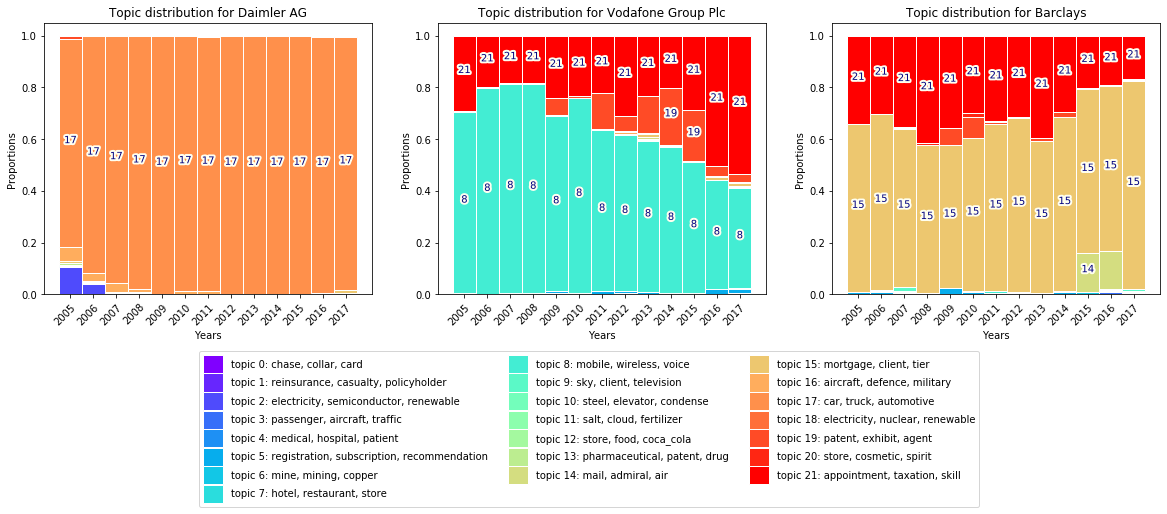

In [49]:
f, axs = plt.subplots(1, 3, figsize=(20, 5))

for column_index, ticker in enumerate(['DAI_DAX','VOD_FTSE','BARC_FTSE']):
    ax = axs[column_index]
    
    bar_width = 1
    bar_l = [i for i in range(len(year_series))]
    tick_pos = [i for i in bar_l]
    
    ax.set_title("Topic distribution for %s" % (companies_names[ticker]))
    ax.set_ylabel("Proportions")
    ax.set_xlabel("Years")
    
    on_bottom = np.zeros(len(year_series))
    patch_handles = []
    for topic_id in range(number_of_topics):
        plot_data = [topic_proportions_data[year][ticker][topic_id] for year in year_series] 
        patch_handles.append(
            ax.bar(
                bar_l, 
                plot_data, 
                bottom=on_bottom, 
                label="topic %s: %s" % (topic_id,", ".join(top_n_terms[topic_id][:take_top_terms])),
                color=colors_topic[topic_id], width=bar_width, edgecolor='white')
        )
        on_bottom = [previous + current for previous, current in zip(on_bottom, plot_data)]
    
    for topic_id in range(len(patch_handles)):
        for year_index, patch in enumerate(patch_handles[topic_id].get_children()):
            if topic_proportions_data[year_series[year_index]][ticker][topic_id] >= 0.15:
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                t = ax.text(x,y, topic_id, ha='center', color='navy')
                t.set_path_effects([
                        path_effects.Stroke(linewidth=4,foreground='ivory'),
                        path_effects.Normal()])
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(year_series, rotation=45, rotation_mode="anchor", horizontalalignment='right')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(-0.74, -0.8), loc="lower center", ncol=3, handleheight=2.4, labelspacing=0.05)

#save plot
pp = PdfPages(os.path.join(dir_topic_proportion_plots, "3_companies.pdf"))
plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()


# Weighting

In [50]:
mask_file_weight_nnls = "year-%d-weights-nnls.csv"
mask_file_weight_lstsq_fn = "year-%d-weights-lstsq-fn.csv"

In [51]:
dir_result_weight_matrices = os.path.join(dir_result_interpretation, 'weight_matrices')
if not os.path.exists(dir_result_weight_matrices):
    os.makedirs(dir_result_weight_matrices)

## Get weight matrix

In [52]:
tickers_in_order = []
for year in year_series:
    tickers_list = []
    file = os.path.join(dir_result_topics_proportions, "topic-proportion-%d.csv" % year)
    line_index = 0
    rows = []
    with open(file, 'r') as f_r:
        for text_line in f_r:
            if line_index == 0:
                tickers_list = text_line.strip().split(',')
            else:
                row = list(map(float, text_line.strip().split(',')))
                rows.append(row)
            line_index += 1
    
    tickers_in_order = tickers_list
    
    A = np.array(rows)
    x_lstsq_fn_lists = list()
    for topic_id in range(number_of_topics):
        b = np.zeros(number_of_topics)
        b[topic_id] = 1.0
        
        # LSTSQ
        x_lstsq = np.linalg.lstsq(A, b, rcond = None)
        x_lstsq_fn_lists.append([x for x in x_lstsq[0]])
        
    file = os.path.join(dir_result_weight_matrices, mask_file_weight_lstsq_fn % year)
    with open(file, 'w') as f_w:
        for index in range(len(tickers_list)):
            entry = list()
            entry.append(tickers_list[index])
            for topic_id in range(number_of_topics):
                entry.append(x_lstsq_fn_lists[topic_id][index])
            f_w.write("%s\n" % ','.join(list(map(str, entry))))

## Plot weights

### weights for lstsq

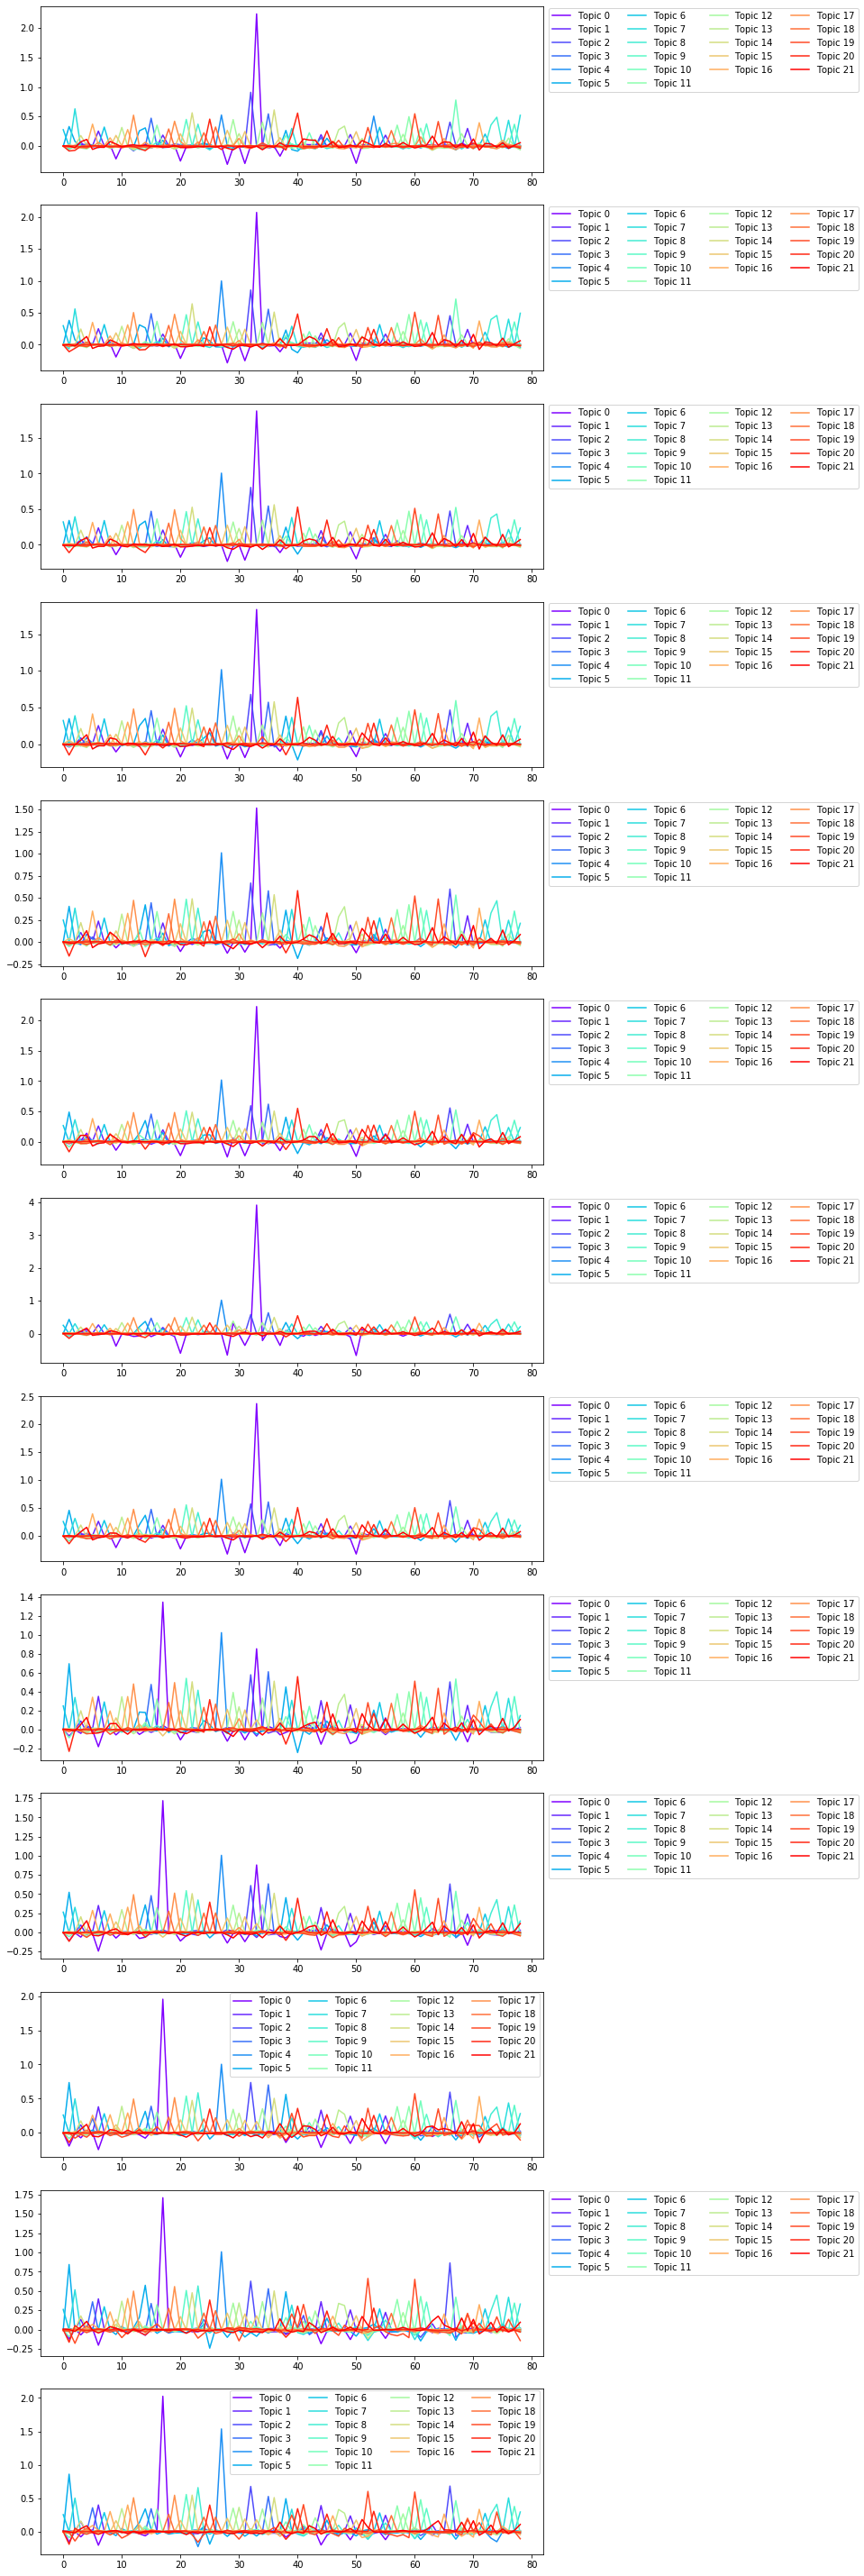

In [53]:
f, ax = plt.subplots(len(year_series), 1, figsize=(10, 4*len(year_series)))
column_names = ['Ticker']
topic_names = []
topic_numbers = []
for topic_id in range(number_of_topics):
    column_names.append("Topic %s" % topic_id)
    topic_names.append("Topic %s" % topic_id)
    topic_numbers.append([])
for year_index, year in enumerate(year_series):
    file_weights = os.path.join(dir_result_weight_matrices, mask_file_weight_lstsq_fn % year)
    df_weights = pd.read_csv(open(file_weights, 'r'), header=None, names=column_names)
    for topic_id, topic_name in enumerate(topic_names):
        ax[year_index,].plot(df_weights[topic_name], label=topic_name, color=colors_topic[topic_id])
    ax[year_index,].legend(ncol=4, bbox_to_anchor=(1.002, 1.019))

## Get Return

In [54]:
initial_amount_to_invest = 1

In [55]:
df_returns_koef = pd.read_csv(os.path.join(dir_run, "%s-returns.csv" % run_prefix))
df_returns_koef.rename(index=str, columns={'Unnamed: 0': 'Date'}, inplace=True)
df_returns_koef['Date'] = pd.to_datetime(df_returns_koef['Date'])

Check if tickers_in_oreder list is available and sorted

In [56]:
for ticker in tickers_in_order:
    print(ticker)

AAL_FTSE
ACA_CAC
AC_CAC
ADM_FTSE
AGK_FTSE
AIR_CAC
ALV_DAX
ANTO_FTSE
BAB_FTSE
BARC_FTSE
BAYN_DAX
BA_FTSE
BMW_DAX
BNP_CAC
CAP_CAC
CBK_DAX
CSCO_DJIA
CS_CAC
CVX_DJIA
DAI_DAX
DBK_DAX
DIS_DJIA
DPW_DAX
DTE_DAX
EDF_CAC
EI_CAC
EOAN_DAX
FRE_DAX
GS_DJIA
HD_DJIA
HEN3_DAX
HSBC_DJIA
IFX_DAX
JPM_DJIA
KO_DJIA
LHA_DAX
LIN_DAX
LLOY_FTSE
LR_CAC
MCD_DJIA
MC_CAC
MKS_FTSE
MRO_FTSE
MRW_FTSE
MUV2_DAX
OR_CAC
PFC_FTSE
PFE_DJIA
PG_DJIA
PRU_FTSE
RBS_FTSE
RB_FTSE
REL_FTSE
RI_CAC
RRS_FTSE
RSA_FTSE
RWE_DAX
SAP_DAX
SBRY_FTSE
SDF_DAX
SHP_FTSE
SIE_DAX
SKY_FTSE
SLA_FTSE
SNN_FTSE
SRP_FTSE
SSE_FTSE
TKA_DAX
TSCO_FTSE
TVE_DJIA
ULVR_FTSE
UTX_DJIA
VED_FTSE
VOD_FTSE
VZ_DJIA
WEIR_FTSE
WMT_DJIA
WPP_FTSE
WTB_FTSE


Check if directory for returns is created

In [57]:
dir_result_portfolio = os.path.join(dir_result_interpretation, 'return')
if not os.path.exists(dir_result_portfolio):
    os.makedirs(dir_result_portfolio)

In [58]:
df_returns_invest = df_returns_koef[['Date']].copy()

for topic_id in range(number_of_topics):
    investition = initial_amount_to_invest;
    return_year_topic_invest = []

    for year in year_series:
        current_year = year + 1
        topic_name = topic_names[topic_id]

        file_weights = os.path.join(dir_result_weight_matrices, mask_file_weight_lstsq_fn % year)
        df_weights = pd.read_csv(open(file_weights, 'r'), header=None, names=column_names)
        weights_topic_year = df_weights[topic_name].to_numpy()

        return_year_stocks_koef = (df_returns_koef[df_returns_koef['Date'].dt.year  == current_year][tickers_in_order]).to_numpy()

        return_year_topic_koef = return_year_stocks_koef.dot(np.transpose(weights_topic_year))
        #print(return_year_topic)
        #print(return_year_topic.shape)

        for koef in return_year_topic_koef:
            investition *= koef
            return_year_topic_invest.append(investition)

    df_returns_invest[topic_names[topic_id]] = return_year_topic_invest
    #print(return_year_topic_invest)


df_returns_invest.set_index('Date', inplace=True)
#print(df_returns_invest.tail())

with open(os.path.join(dir_result_portfolio, "results-returns_dataframe.csv"), 'w') as f_w:
    df_returns_invest.to_csv(f_w);


# Plots

## Returns

### Plot per topic

In [59]:
dir_return_plots = os.path.join(dir_result_interpretation, 'return_plots')
if not os.path.exists(dir_return_plots):
    os.makedirs(dir_return_plots)

#### Read indecies mappings and timeseries 

In [60]:
dir_ticker_mappings = os.path.join(dir_data_raw, 'topics_industries_mapping')
file_indicies_mapping = os.path.join(dir_ticker_mappings, 'mapping.json')
dir_ticker_prices = os.path.join(dir_data, 'prices')
file_indices_table = os.path.join(dir_ticker_prices, 'all-industries-indices.csv')

In [61]:
topic_industries_mapping = {}
topic_industries_meta = {}
with open(file_indicies_mapping, 'r') as f_r:
    mappings = json.load(f_r)
    for mapping in mappings:
        if mapping['ticker']:
            topic_industries_mapping[mapping['topic_id']] = mapping['ticker']
            topic_industries_meta[mapping['topic_id']] = mapping['index_name']

In [62]:
df_indices_returns = pd.read_csv(file_indices_table)
df_indices_returns.rename(index=str, columns={'Unnamed: 0': 'Date'}, inplace=True)
df_indices_returns['Date'] = pd.to_datetime(df_indices_returns['Date'])
df_indices_returns.set_index('Date', inplace=True)
df_indices_returns.head()

,XLF,KIE,XLK,XTN,XHS,XME,PEJ,XLC,XHB,XLB,XLP,XLV,XLI,XLRE,XAR,CARZ,XLE,XHE,XLY
Date,,,,,,,,,,,,,,,,,,,
2006-01-03,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,1.000000
2006-01-04,0.999068,1.020758,1.011731,NaN,NaN,NaN,1.007175,NaN,NaN,1.006145,1.003413,1.009966,1.002529,NaN,NaN,NaN,1.002846,NaN,1.000909
2006-01-05,1.002485,1.020567,1.016425,NaN,NaN,NaN,1.007828,NaN,NaN,1.004528,0.998294,1.007475,1.000949,NaN,NaN,NaN,0.990133,NaN,1.001818
2006-01-06,1.008385,1.023996,1.032379,NaN,NaN,NaN,1.019570,NaN,NaN,1.015200,1.002559,1.014015,1.004742,NaN,NaN,NaN,1.014421,NaN,1.010000
2006-01-09,1.011180,1.025709,1.035664,NaN,NaN,NaN,1.024136,NaN,NaN,1.014877,1.007252,1.018686,1.012963,NaN,NaN,NaN,1.013283,NaN,1.020303


#### Scale industry indecies to topic if they don't start at the same day

In [63]:
list_returns_per_topic_index = []

for topic_id in range(number_of_topics):
    topic_literal = topic_names[topic_id]
    if topic_id in topic_industries_mapping:
        index_literal = topic_industries_mapping[topic_id]
        df_merge = pd.merge(
            df_returns_invest[topic_literal],
            df_indices_returns[index_literal],
            on='Date',
            how='outer'
        )
        df_merge.fillna(method='ffill', inplace=True)
        first_valid_index = df_indices_returns[index_literal].first_valid_index()
        scaling_value = df_merge.at[first_valid_index,topic_literal]
        df_merge[index_literal] = df_merge[index_literal]*scaling_value
        print('Topic: %s First valid index: %s Scaling value: %s' % (topic_id, first_valid_index, scaling_value))
    else: 
        df_merge = new = df_returns_invest[[topic_literal]].copy()
        print('Topic: %s no industry data' % (topic_id))
    
    list_returns_per_topic_index.append(df_merge)        

Topic: 0 First valid index: 2006-01-03 00:00:00 Scaling value: 0.999589501257549
Topic: 1 First valid index: 2006-01-03 00:00:00 Scaling value: 1.0003511989013103
Topic: 2 First valid index: 2006-01-03 00:00:00 Scaling value: 1.00656289238909
Topic: 3 First valid index: 2011-01-27 00:00:00 Scaling value: 0.6226853114937924
Topic: 4 First valid index: 2011-09-29 00:00:00 Scaling value: 1.8639467791530662
Topic: 5 no industry data
Topic: 6 First valid index: 2006-06-22 00:00:00 Scaling value: 1.1536660062983415
Topic: 7 First valid index: 2006-01-03 00:00:00 Scaling value: 1.0074004827940477
Topic: 8 First valid index: 2018-06-19 00:00:00 Scaling value: 2.4656322030825844
Topic: 9 no industry data
Topic: 10 First valid index: 2006-02-06 00:00:00 Scaling value: 1.096603880369047
Topic: 11 First valid index: 2006-01-03 00:00:00 Scaling value: 1.0147314657883546
Topic: 12 First valid index: 2006-01-03 00:00:00 Scaling value: 1.0007010068940294
Topic: 13 First valid index: 2006-01-03 00:00:0

In [64]:
list_returns_per_topic_index[0].head()

,Topic 0,XLF
Date,,
2006-01-01,1.000000,NaN
2006-01-02,1.000000,NaN
2006-01-03,0.999590,0.999590
2006-01-04,0.979630,0.998658
2006-01-05,0.989212,1.002073


In [65]:
def generate_subpots_indices(rows, columns, page):
    for row in range(rows):
        for column in range(columns):
            topic_id = (rows * columns * page) + (row * columns) + column
            yield row, column, topic_id

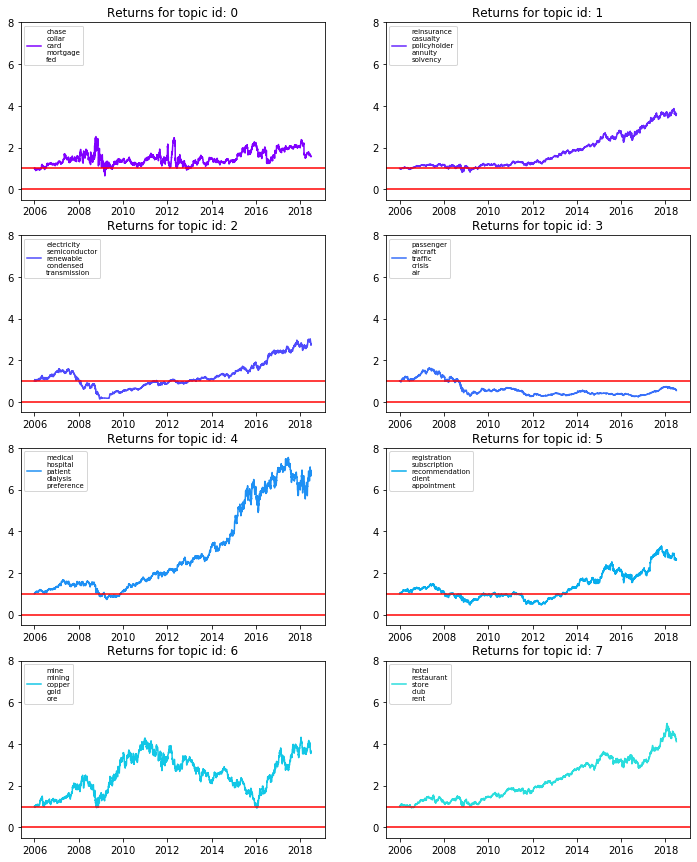

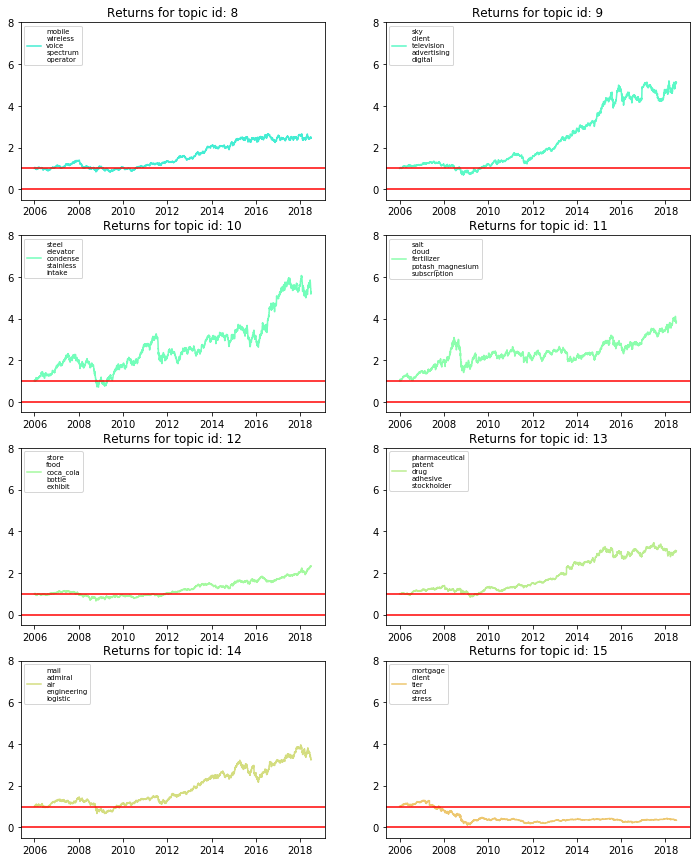

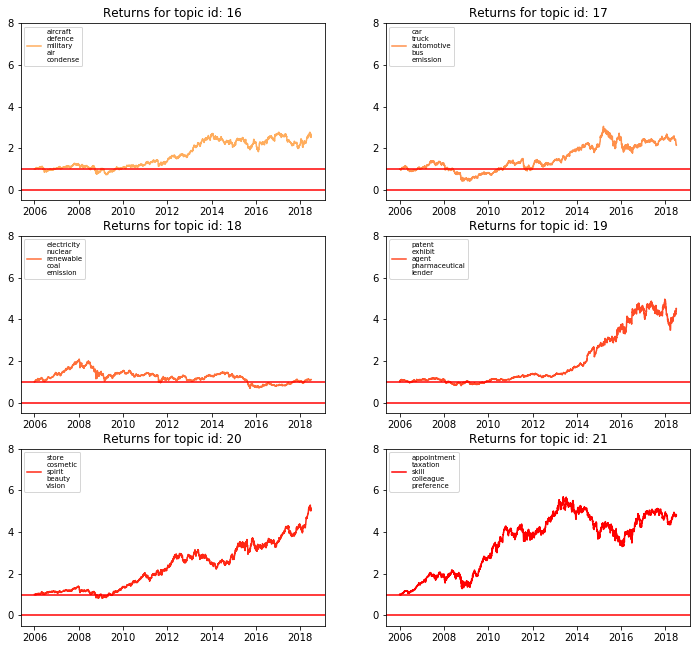

In [66]:
columns = 2
rows = 4
per_page = rows * columns
pages = math.ceil(number_of_topics / per_page)

for page in range(pages):
    f, ax = plt.subplots(
        rows,
        columns,
        figsize=(12,15))
    text_box_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for row, column, topic_id in generate_subpots_indices(rows, columns, page):
        if topic_id < number_of_topics:
            #Construct terms
            file_csv_sorted_terms_summary = os.path.join(dir_result_top_terms, '%03d-terms-summary.csv' % topic_id)
            terms_box = '\n'.join([x.strip() for x in open(file_csv_sorted_terms_summary, 'r')])
            terms_label = ', '.join([x.strip() for x in open(file_csv_sorted_terms_summary, 'r')])
            topic_literal = topic_names[topic_id]
            ax[row, column].plot(
                list_returns_per_topic_index[topic_id][topic_literal],
                color=colors_topic[topic_id],
                label=terms_box
            )
            #plot mapped index if available
            if flag_plot_industries_indecies:
                if topic_id in topic_industries_mapping:
                    index_literal = topic_industries_mapping[topic_id]
                    ax[row, column].plot(
                        list_returns_per_topic_index[topic_id][index_literal],
                        color='black',
                        label='%s %s' % (topic_industries_mapping[topic_id], topic_industries_meta[topic_id])
                    )

            ax[row, column].set_ylim(-0.5, 8)
            ax[row, column].set_title('Returns for topic id: %s' % topic_id)
            ax[row, column].axhline(y=1, color='r')
            ax[row, column].axhline(y=0, color='r')

            # create term box and legend
            ax[row, column].legend(
                loc='upper left', 
                fontsize='x-small',
                labelspacing=1.1
            )
            #ax[row, column].text(0.05, 0.95, terms_box, transform=ax[row, column].transAxes, fontsize=10, verticalalignment='top', bbox=text_box_props)
        else:
            ax[row, column].remove()

    pp = PdfPages(os.path.join(dir_return_plots, 'returns_per_topic_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_inches='tight')
    pp.close()    

## Correlation between topics

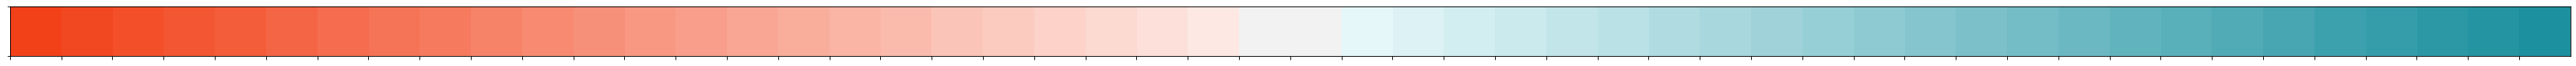

In [67]:
#use color_south_rgba on left
#use color_north_rgba on right
cmap=sns.diverging_palette(16, 208, s=95, l=55, n=50)
sns.palplot(cmap)


In [68]:
dir_correlation_plots = os.path.join(dir_result_interpretation, 'correlation_plots')

In [69]:
if not os.path.exists(dir_correlation_plots):
    os.mkdir(dir_correlation_plots)

### Pearson correlation

In [70]:
corr_topics = df_returns_invest[topic_names].corr(method='pearson')
mask_corr_topics = np.triu(np.ones_like(corr_topics, dtype=np.bool))

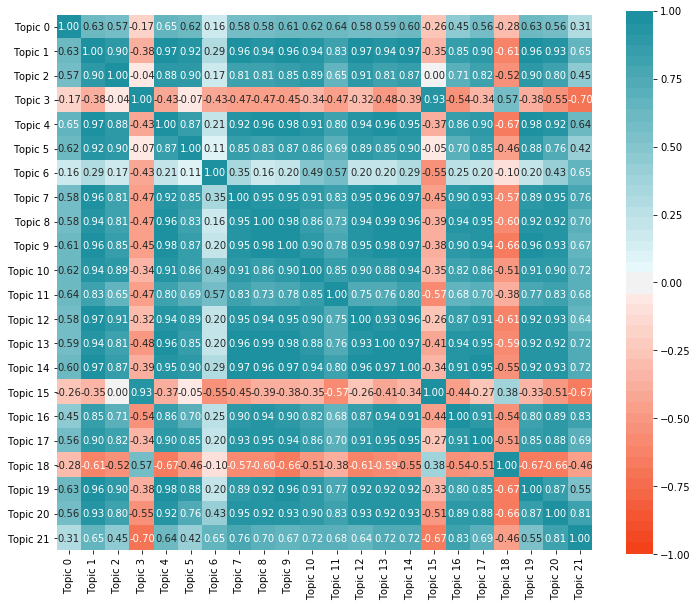

In [71]:
fig, ax = plt.subplots(figsize=(12, 10))


sns.heatmap(corr_topics, 
            cmap=cmap, 
            annot = True, 
            vmin = -1, 
            vmax = 1, 
            center = 0,
            square = True,
            fmt = ".2f",
           )


pp = PdfPages(os.path.join(dir_correlation_plots, 'heat_map_correlation_topics.pdf'))
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()   

#plt.show()

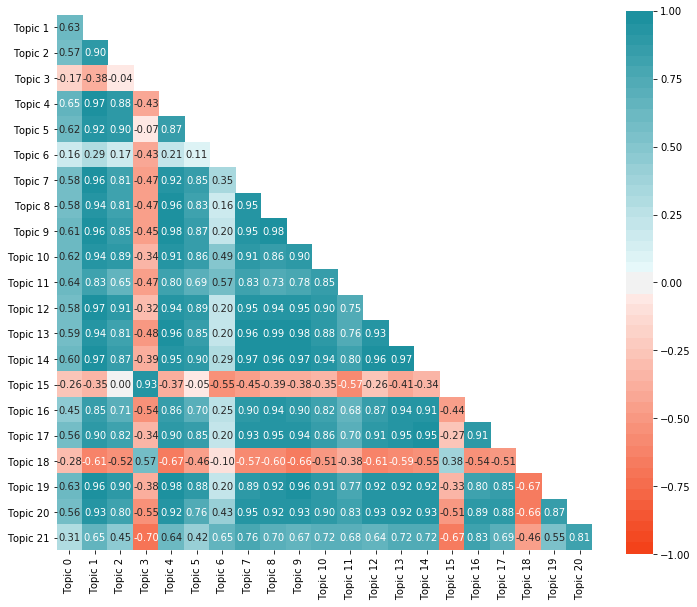

In [72]:
fig, ax = plt.subplots(figsize=(12, 10))


# adjust mask and df
mask = mask_corr_topics[1:, :-1]
corr = corr_topics.iloc[1:,:-1].copy()

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            annot = True, 
            vmin = -1, 
            vmax = 1, 
            center = 0,
            square = True,
            #linewidths = 1,
            fmt = ".2f",
           )

#plt.title('Heat Map correlation')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

pp = PdfPages(os.path.join(dir_correlation_plots, 'heat_map_correlation_diagonal_topics.pdf'))
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()   

#plt.show()

Heat Map correlation


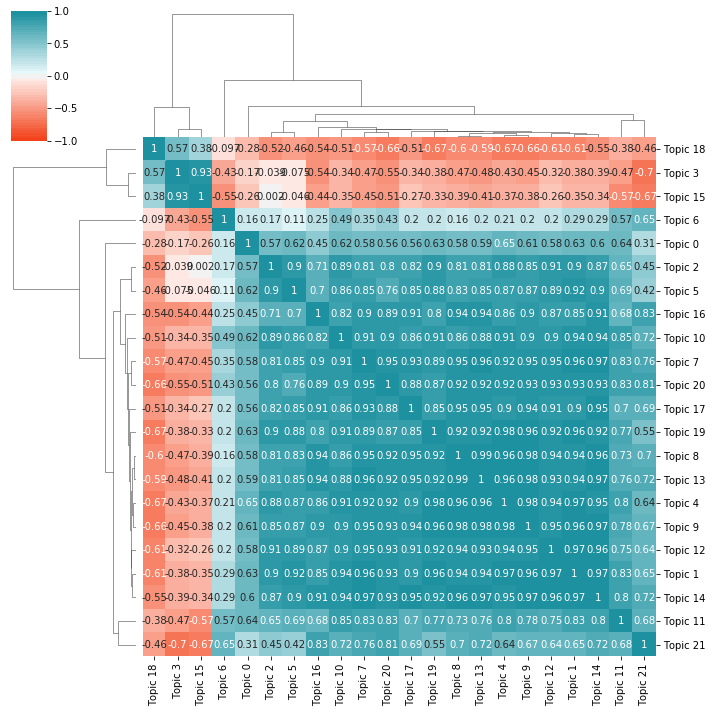

In [73]:
sns.clustermap(corr_topics, cmap=cmap, annot = False, vmin = -1, vmax = 1, center = 0)
print('Heat Map correlation')

# End